# USA - FINAL MODEL

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
import itertools
import re
from math import sqrt
import os
import warnings
import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

E:\Ananconda_Installation\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
E:\Ananconda_Installation\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## 1. Reading Data

In [2]:
df_unemployment=pd.read_csv(r'E:\Jupyter notebooks\hackathon23_somnolence\data\raw\third_party\oecd\Unemployment_Rate_OECD.csv')
df_unemployment.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HUR,TOT,PC_LF,A,1967,1.875,NaN
1,AUS,HUR,TOT,PC_LF,A,1968,1.850,NaN
2,AUS,HUR,TOT,PC_LF,A,1969,1.800,NaN
3,AUS,HUR,TOT,PC_LF,A,1970,1.625,NaN
4,AUS,HUR,TOT,PC_LF,A,1971,1.925,NaN


In [3]:
df_unemployment['LOCATION'].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CZE', 'DNK', 'FIN', 'FRA', 'DEU',
       'GRC', 'HUN', 'ISL', 'IRL', 'ITA', 'JPN', 'KOR', 'LUX', 'MEX',
       'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'ESP', 'SWE', 'CHE',
       'TUR', 'GBR', 'USA', 'CHL', 'EST', 'ISR', 'SVN', 'OECD', 'G-7',
       'EA19', 'LVA', 'LTU', 'COL', 'EU27_2020', 'CRI'], dtype=object)

In [4]:
#Location variable to control country
location='USA'

In [5]:
df_unemployment=df_unemployment[(df_unemployment['LOCATION']==location)&(df_unemployment['SUBJECT']=='TOT')].copy()
df_unemployment_monthly=df_unemployment[df_unemployment['TIME'].str.contains(r'\d{4}\-\d{2}',regex=True)]
df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')
df_unemployment_monthly=df_unemployment_monthly.set_index('TIME')

C:\Users\PRADEEP SINGH\AppData\Local\Temp\ipykernel_10620\495960325.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unemployment_monthly['TIME']=pd.to_datetime(df_unemployment_monthly['TIME'],format='%Y-%m')


In [6]:
df_unemployment_monthly

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,Value,Flag Codes
TIME,,,,,,,
1955-01-01,USA,HUR,TOT,PC_LF,M,4.9,NaN
1955-02-01,USA,HUR,TOT,PC_LF,M,4.7,NaN
1955-03-01,USA,HUR,TOT,PC_LF,M,4.6,NaN
1955-04-01,USA,HUR,TOT,PC_LF,M,4.7,NaN
1955-05-01,USA,HUR,TOT,PC_LF,M,4.3,NaN
...,...,...,...,...,...,...,...
2022-11-01,USA,HUR,TOT,PC_LF,M,3.6,NaN
2022-12-01,USA,HUR,TOT,PC_LF,M,3.5,NaN
2023-01-01,USA,HUR,TOT,PC_LF,M,3.4,NaN


## 2. Univariate Time Series ARIMA

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

### 2.1. EDA

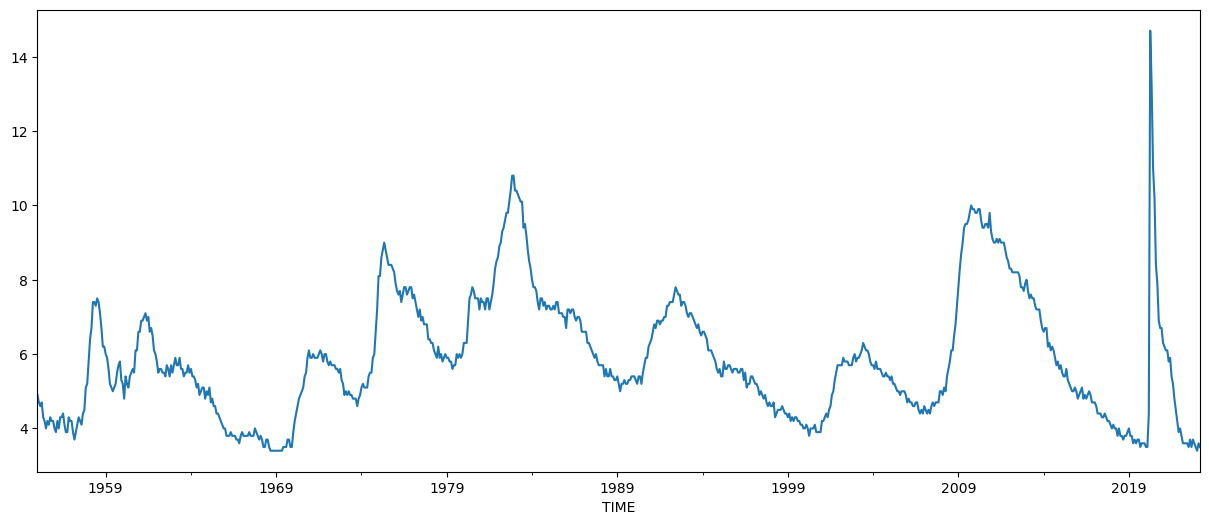

In [7]:
df_unemployment_monthly['Value'].plot(figsize=(15, 6))
plt.show()

#### 2.1.1. Decomposing Time Series to Trend, Seasonality and Residuals

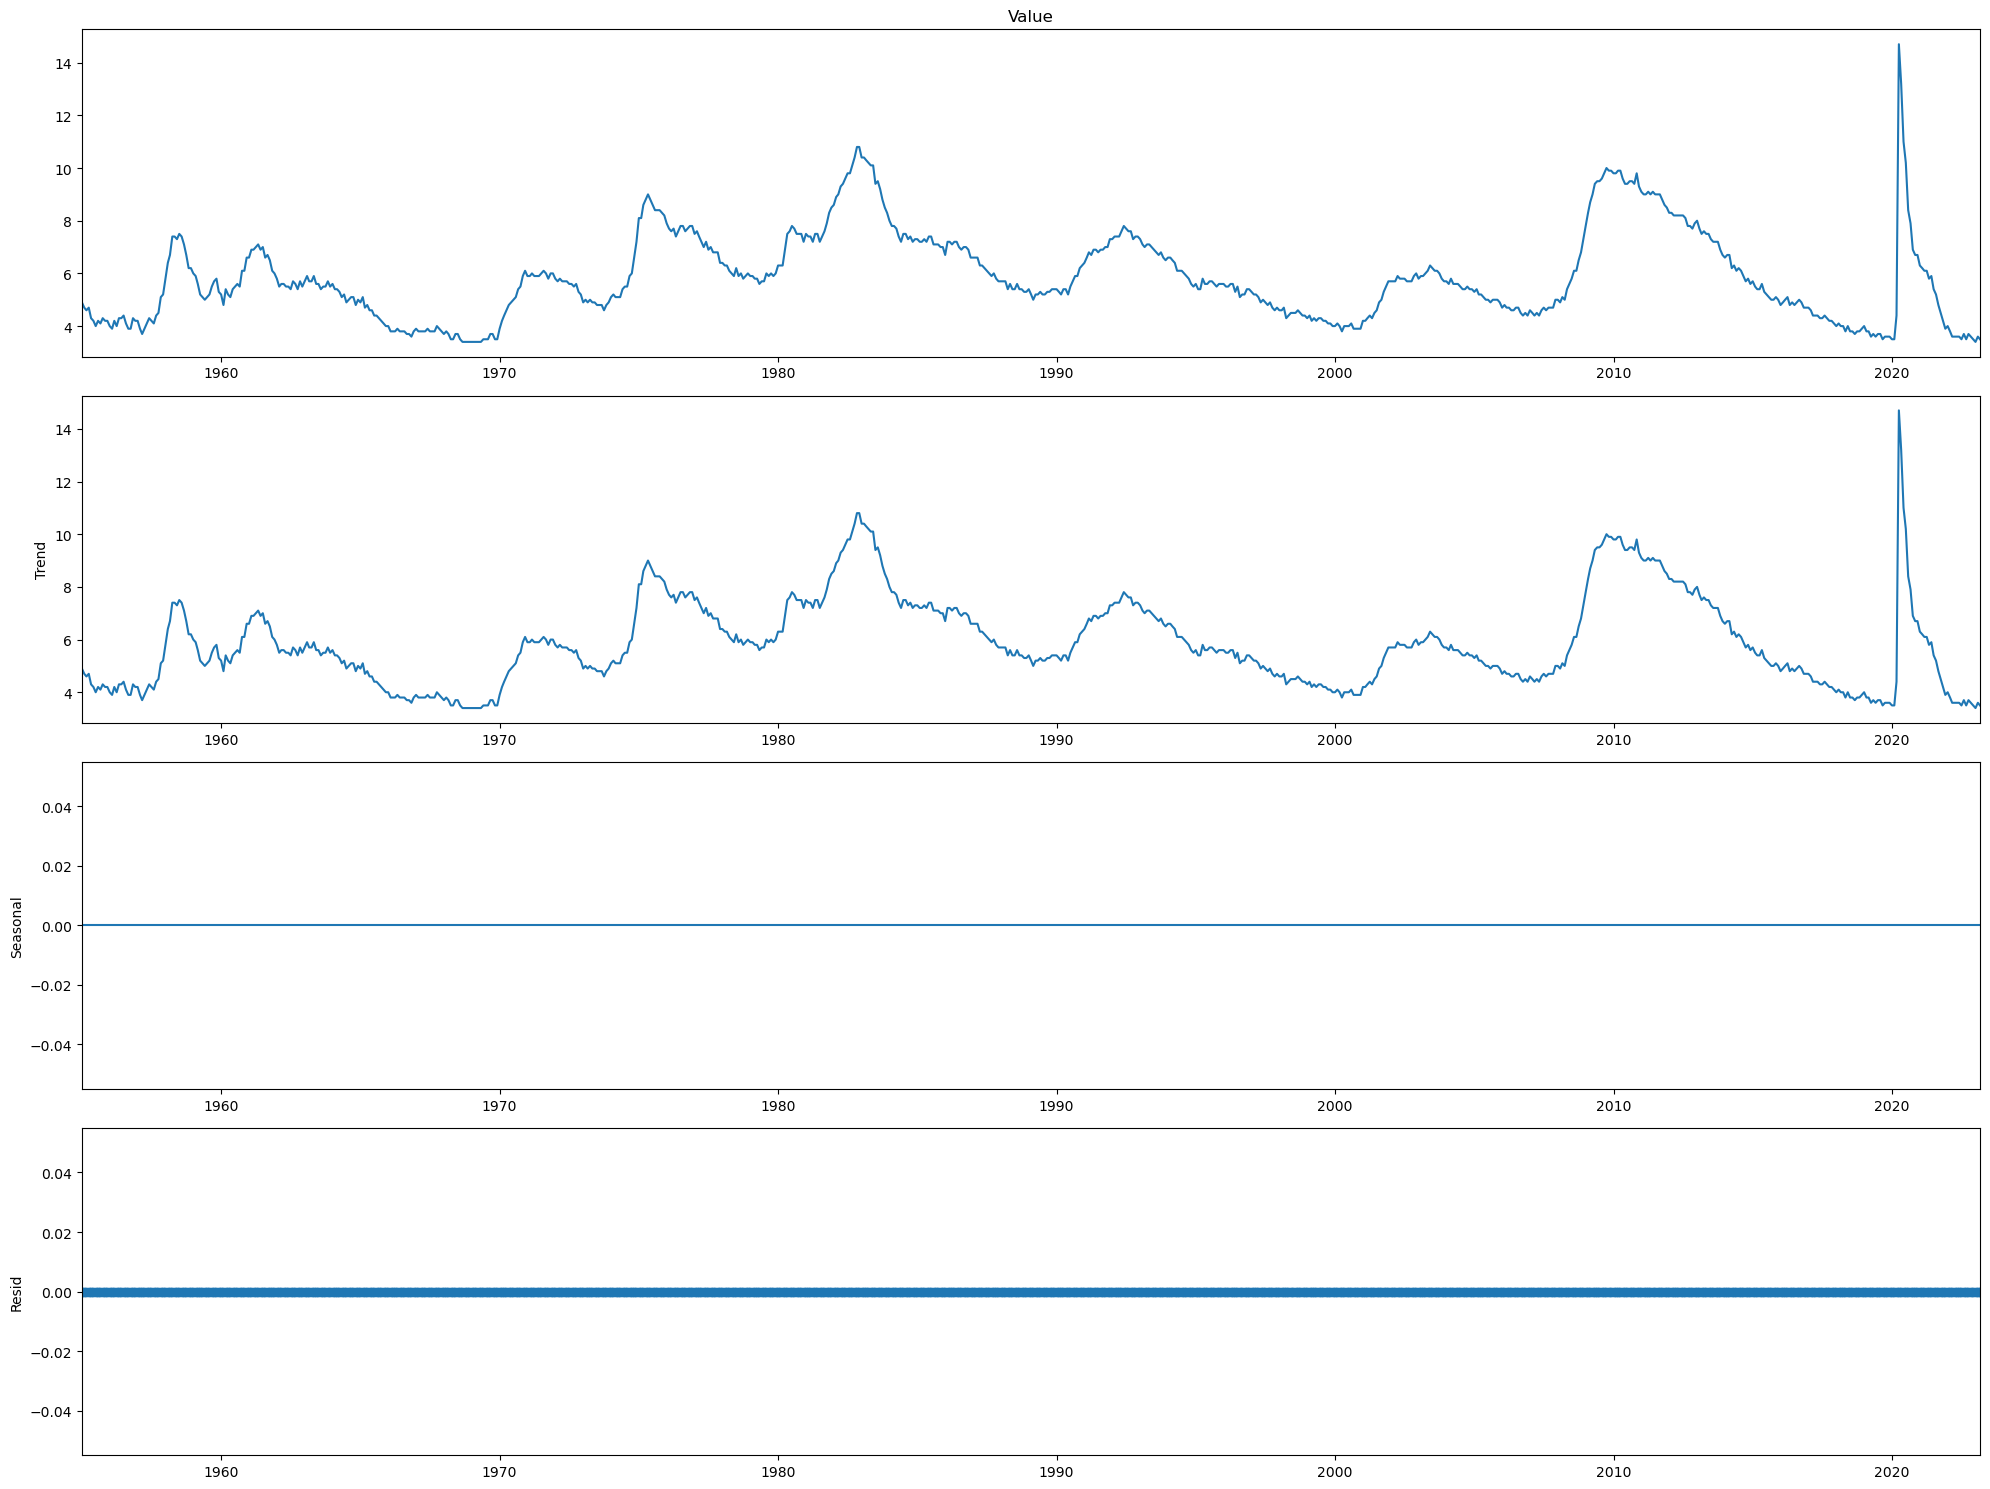

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15
decomposition = sm.tsa.seasonal_decompose(df_unemployment_monthly['Value'], model='additive',period=1)
fig = decomposition.plot()
plt.show()

#### 2.1.2. Checking Stationarity

In [9]:
adfuller_result = adfuller(df_unemployment_monthly['Value'].values, autolag='AIC')
print('ADF statistics: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])
if adfuller_result[1] >= 0.05:
    print('------Non-stationary time series. Checking first difference------------')
    df_unemployment_monthly_transformed = df_unemployment_monthly['Value'].diff().dropna()
    adfuller_result = adfuller(df_unemployment_monthly_transformed.values, autolag='AIC')
    print('ADF statistics at first difference: ', adfuller_result[0])
    print('p-value: ', adfuller_result[1])
else:
    print('Stationary time series')

ADF statistics:  -3.7484325668092677
p-value:  0.0034812456476752338
Stationary time series


### 2.2. Modelling 

In [10]:
train_limit=df_unemployment_monthly.shape[0]-12

Y_train=df_unemployment_monthly.iloc[0:train_limit,5]
Y_validation=df_unemployment_monthly.iloc[train_limit:,5]
Y_full=df_unemployment_monthly.iloc[:,5]

#### 2.2.1. Determining optimum p,d,q values

In [11]:
%%time

def evaluate_sarimax_model(Y_train, Y_validation, order):
    mod = sm.tsa.statespace.SARIMAX(Y_train,
                                    order=order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_arima_model(Y_train, Y_validation, order):
    mod = ARIMA(Y_train,
                order=order)
    results = mod.fit()
    
    predictions={}
    for date in Y_validation.index:
        pred=results.get_prediction(pd.to_datetime(date))
        predictions[date]=pred.predicted_mean[0]
        
    y_forecasted = np.array(list(predictions.values()))
    y_truth = Y_validation.values
    mse = ((y_forecasted - y_truth) ** 2).mean()
    return sqrt(mse)

def evaluate_models(dataset, validation_dataset,p_values,d_values,q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                rmse = evaluate_arima_model(dataset, validation_dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%s' % (order,rmse))

    print('Best ARIMA%s RMSE= %s' % (best_cfg, best_score))
    return best_cfg
    
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg=evaluate_models(Y_train, Y_validation, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.3447821775663873
ARIMA(0, 0, 1) RMSE=2.2663813103377928
ARIMA(0, 0, 2) RMSE=2.218516298978354
ARIMA(0, 1, 0) RMSE=0.09128709291752778
ARIMA(0, 1, 1) RMSE=0.08845317879994605
ARIMA(0, 2, 1) RMSE=0.0861614804739525
ARIMA(0, 2, 2) RMSE=0.08419238740774851
Best ARIMA(0, 2, 2) RMSE= 0.08419238740774851
Wall time: 2min 12s


In [12]:
# stepwise_fit = auto_arima(Y_train, start_p=0,max_p=10, start_d=2, max_d=3, start_q =0, max_q=3,trace=True,suppress_warnings=True)
# stepwise_fit.summary()

#### 2.2.2. Fitting Model

In [13]:
mod = ARIMA(Y_train,order=best_cfg)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9525      1.299     -0.733      0.463      -3.498       1.593
ma.L2         -0.0475      0.068     -0.696      0.486      -0.181       0.086
sigma2         0.1824      0.237      0.770      0.442      -0.282       0.647


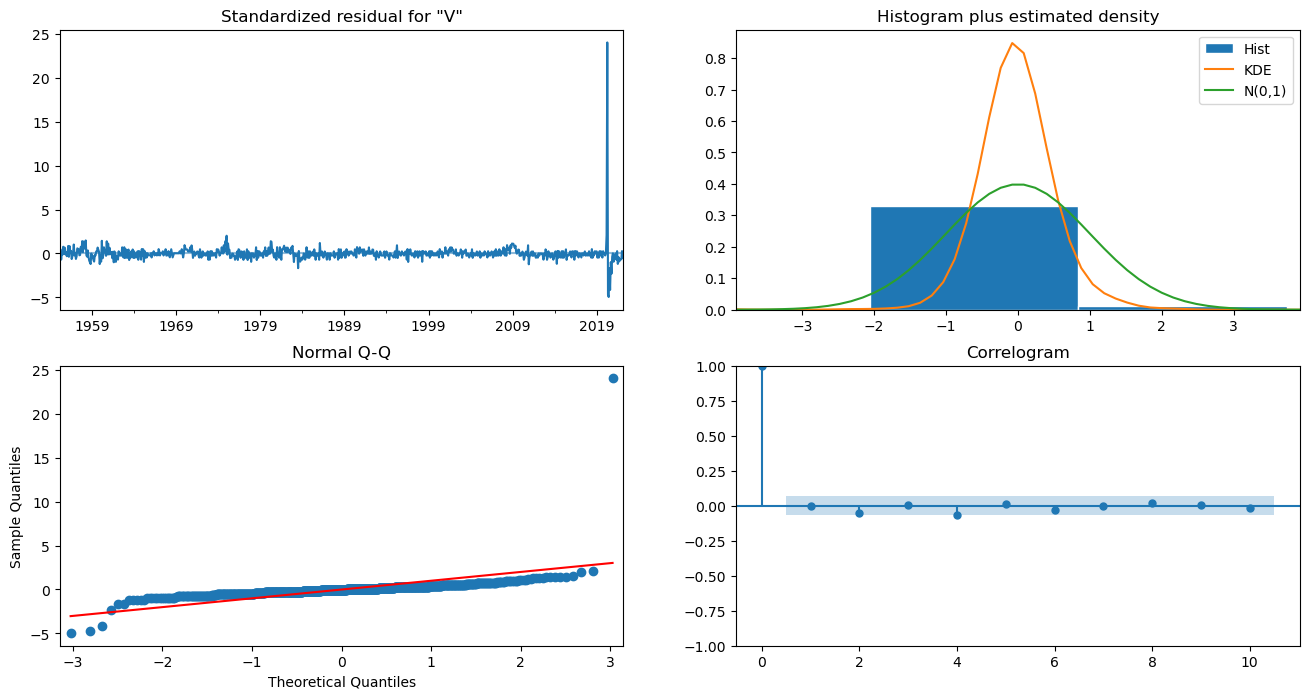

In [14]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### 2.2.3. Model Results

In [15]:
predictions={}
for date in Y_validation.index:
    pred=results.get_prediction(pd.to_datetime(date))
    predictions[date]=pred.predicted_mean[0]

In [16]:
y_forecasted = np.array(list(predictions.values()))
y_truth = Y_validation.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Root Mean Squared Error of our forecasts is {}'.format(sqrt(mse)))

The Root Mean Squared Error of our forecasts is 0.08419238740774851


#### 2.2.4. Training on Full Data and Predicting

In [17]:
mod_full_data = ARIMA(Y_full,order=best_cfg)
results_full_data = mod_full_data.fit()
print(results_full_data.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9537      1.720     -0.554      0.579      -4.325       2.418
ma.L2         -0.0463      0.086     -0.539      0.590      -0.215       0.122
sigma2         0.1800      0.310      0.581      0.561      -0.427       0.787


In [18]:
preds_df = (results_full_data
            .get_prediction(start='2023-01-01', end='2023-05-01')
            .summary_frame(alpha=0.05)
)

preds_df

Value,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-01-01,3.493951,0.424524,2.661898,4.326003
2023-02-01,3.393804,0.424524,2.561752,4.225856
2023-03-01,3.607937,0.424524,2.775886,4.439989
2023-04-01,3.493284,0.424523,2.661233,4.325335
2023-05-01,3.491555,0.614786,2.286596,4.696514
